In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/README.md.txt
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-173.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-334.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-309.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-487.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-178.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-10.png
/kaggle/input/tuberculos

In [34]:
import os
import shutil
from sklearn.utils import shuffle

# Paths to the dataset
original_dir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
reduced_dir = 'balanced_dataset/'  # Path to save the balanced dataset

# Target number of images for the "Normal" class
IMG_PER_NORMAL = 2000

# Function to create a balanced dataset
def balance_dataset(original_dir, reduced_dir, img_per_normal):
    if not os.path.exists(reduced_dir):
        os.makedirs(reduced_dir)
    
    for category in os.listdir(original_dir):
        category_path = os.path.join(original_dir, category)
        
        # Skip non-directories
        if not os.path.isdir(category_path):
            continue
        
        print(f"Processing category: {category}")
        
        images = os.listdir(category_path)
        images = shuffle(images, random_state=42)  # Shuffle images
        
        # For the "Normal" category, limit to the specified number of images
        if category.lower() == "normal":  # Case-insensitive match for "Normal"
            selected_images = images[:img_per_normal]
            print(f"Selected {len(selected_images)} images for category: Normal")
        else:  # Keep all images for other categories
            selected_images = images
            print(f"Selected all {len(selected_images)} images for category: {category}")
        
        # Create category folder in the reduced dataset
        reduced_category_path = os.path.join(reduced_dir, category)
        os.makedirs(reduced_category_path, exist_ok=True)
        
        # Copy the selected images to the new folder
        for img in selected_images:
            src = os.path.join(category_path, img)
            dest = os.path.join(reduced_category_path, img)
            shutil.copy(src, dest)

# Create the balanced dataset
balance_dataset(original_dir, reduced_dir, IMG_PER_NORMAL)

# Check the balanced dataset
for category in os.listdir(reduced_dir):
    category_path = os.path.join(reduced_dir, category)
    print(f"Category: {category}, Number of Images: {len(os.listdir(category_path))}")

Processing category: Tuberculosis
Selected all 700 images for category: Tuberculosis
Processing category: Normal
Selected 2000 images for category: Normal
Category: Tuberculosis, Number of Images: 700
Category: Normal, Number of Images: 2000


In [35]:
reduced_dir

'balanced_dataset/'

In [36]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Paths to the dataset
train_dir = 'balanced_dataset/'

# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data augmentation and preprocessing
datagen = ImageDataGenerator(rescale=1.0 / 255)

data_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Keep order for SMOTE
)

Found 2700 images belonging to 2 classes.


In [37]:
# Function to create a model
def create_model(base_model):
    base_model.trainable = False  # Freeze the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Load base models
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Feature extraction function
def extract_features(model, generator):
    features = model.predict(generator, verbose=1)
    return features.reshape(features.shape[0], -1)  # Flatten features

# Extract features using all architectures
vgg16_features = extract_features(vgg16_base, data_generator)
vgg19_features = extract_features(vgg19_base, data_generator)
inception_features = extract_features(inception_base, data_generator)
xception_features = extract_features(xception_base, data_generator)

# Combine all features into a single dataset
features = np.concatenate([vgg16_features, vgg19_features, inception_features, xception_features], axis=1)

# Get labels
labels = data_generator.classes

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 276ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 265ms/step


In [38]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
balanced_features, balanced_labels = smote.fit_resample(features, labels)

print("Shape of balanced features : ")
print(balanced_features.shape)
print("Shape of balanced labels:")
print(balanced_labels.shape)

# Split the balanced dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    balanced_features, balanced_labels, test_size=0.2, random_state=42
)

print("Shape of x_train")
print(X_train.shape)

print(X_val.shape)
print("Shape of x_val")

print("Shape of y_train : ")
print(y_train.shape)

print("Shape of y_val : ")
print(y_val.shape)

# Print class distribution after SMOTE
unique, counts = np.unique(y_train, return_counts=True)
print(f"Class distribution after SMOTE: {dict(zip(unique, counts))}")

Shape of balanced features : 
(4000, 201728)
Shape of balanced labels:
(4000,)
Shape of x_train
(3200, 201728)
(800, 201728)
Shape of x_val
Shape of y_train : 
(3200,)
Shape of y_val : 
(800,)
Class distribution after SMOTE: {0: 1578, 1: 1622}


In [39]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Choose an appropriate number of components
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)

print(X_train_reduced.shape)
print(X_val_reduced.shape)

# print(X_train_reduced.shape)
# print(X_val_reduced.shape)

# Create ensemble model with Logistic Regression classifiers for each architecture
ensemble_model = VotingClassifier(
    estimators=[
        ('VGG16', LogisticRegression(solver='saga', max_iter=100)),
        ('VGG19', LogisticRegression(solver='saga', max_iter=100)),
        ('Inception', LogisticRegression(solver='saga', max_iter=100)),
        ('Xception', LogisticRegression(solver='saga', max_iter=100)),
    ],
    voting='hard',  # Hard voting
)

# Fit the ensemble model on the SMOTE-balanced dataset
history = ensemble_model.fit(X_train_reduced, y_train)

# Evaluate on the validation set
y_pred = ensemble_model.predict(X_val_reduced)

# Generate and print the classification report
print(classification_report(y_val, y_pred))


(3200, 50)
(800, 50)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       422
           1       0.99      0.99      0.99       378

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [40]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.99


In [41]:
from sklearn.metrics import precision_score

precision = precision_score(y_val, y_pred)
print(f"Precision: {precision:.2f}")


Precision: 0.99


In [42]:
from sklearn.metrics import recall_score

recall = recall_score(y_val, y_pred)
print(f"Recall: {recall:.2f}")


Recall: 0.99


In [43]:
from sklearn.metrics import f1_score

f1 = f1_score(y_val, y_pred)
print(f"F1 Score: {f1:.2f}")


F1 Score: 0.99


In [44]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[419   3]
 [  4 374]]


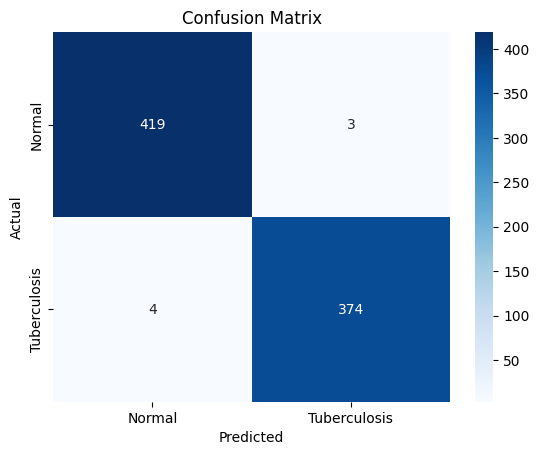

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tuberculosis'], yticklabels=['Normal', 'Tuberculosis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


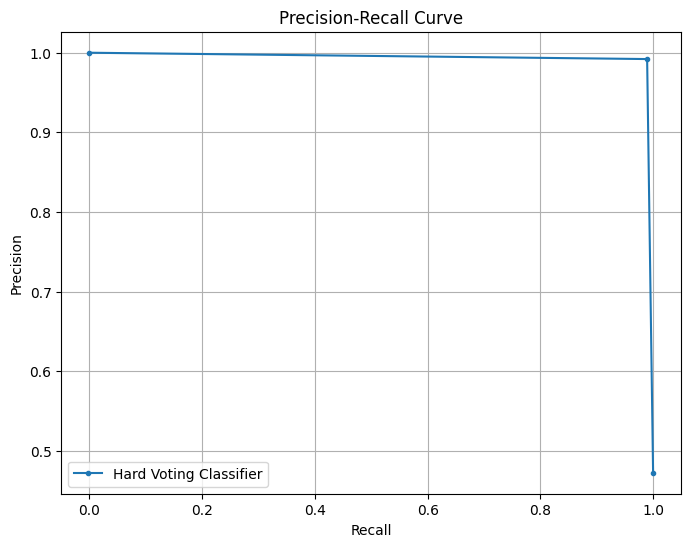

In [46]:
from sklearn.metrics import precision_recall_curve

# Generate a dummy probability array for visualization (if available)
# Replace this with real probabilities if you're using "soft" voting in other models
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Hard Voting Classifier')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()


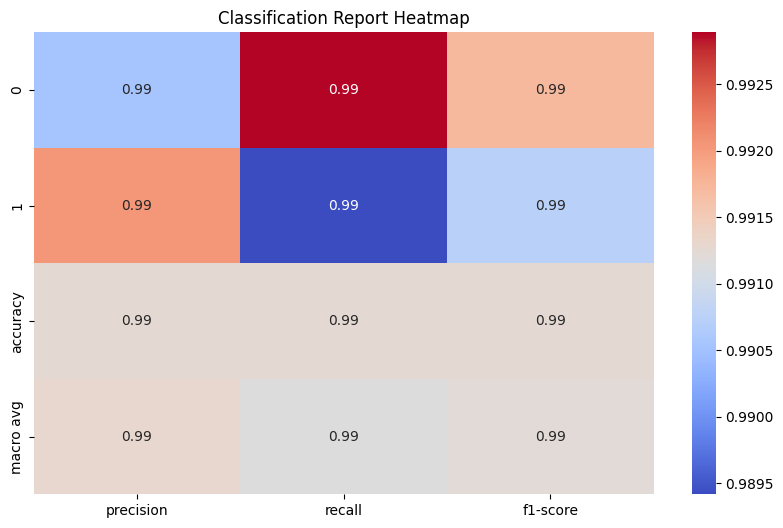

In [47]:
from sklearn.metrics import classification_report
import pandas as pd

# Get classification report
report = classification_report(y_val, y_pred, output_dict=True)

# Convert to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Plot as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm')
plt.title('Classification Report Heatmap')
plt.show()


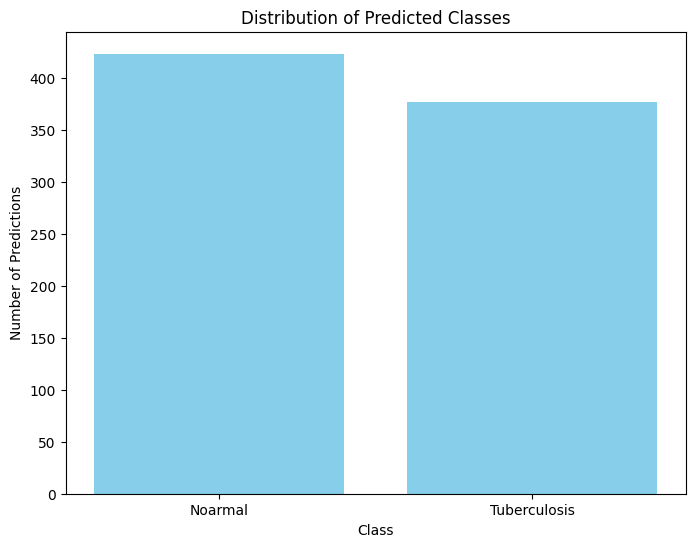

In [48]:
import numpy as np

# Count predictions for each class
unique, counts = np.unique(y_pred, return_counts=True)

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(unique, counts, tick_label=['Noarmal', 'Tuberculosis'], color='skyblue')
plt.title('Distribution of Predicted Classes')
plt.xlabel('Class')
plt.ylabel('Number of Predictions')
plt.show()